In [1]:
import os
import pandas as pd
import geopandas as gpd

# new import statements
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# ML overview

#### Covid deaths analysis

- Source: https://data.dhsgis.wi.gov/
    - Specifically, let's analyze "COVID-19 Data by Census Tract V2": https://data.dhsgis.wi.gov/datasets/wi-dhs::covid-19-data-by-census-tract-v2/explore
        - Status Flag Values: -999: Census tracts, municipalities, school districts, and zip codes with 0–4 aggregate counts for any data have been suppressed. County data with 0-4 aggregate counts by demographic factors (e.g., by age group, race, ethnicity) have been suppressed.

In [2]:
# Do not reptitivitely download large datasets
# Save a local copy instead
dataset_file = "covid.geojson"
if os.path.exists(dataset_file):
    print("Reading local file.")
    df = gpd.read_file(dataset_file)
else:
    print("Downloading the dataset.")
    url = "https://dhsgis.wi.gov/server/rest/services/DHS_COVID19/COVID19_WI_V2/MapServer/9/query?outFields=*&where=1%3D1&f=geojson"
    df = gpd.read_file(url)
    df.to_file(dataset_file)

Reading local file.


In [3]:
df.head()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
0,1680894000000,55001950100,NaN,1032,1,0.43,13,0,0.0,0,...,620,361,1680760800000,2870,66.0,3405,Census tract,4.894706e+08,108089.745033,"POLYGON ((-89.72475 44.24769, -89.72492 44.247..."
1,1680894000000,55001950201,NaN,361,0,0.29,5,0,0.0,0,...,168,170,1680760800000,1244,96.0,3406,Census tract,2.277343e+08,97033.719846,"POLYGON ((-89.73892 43.98186, -89.73925 43.982..."
2,1680894000000,55001950202,NaN,669,0,0.00,8,0,0.0,0,...,388,260,1680760800000,2599,146.0,3113,Census tract,1.004937e+09,162456.681081,"POLYGON ((-89.90890 44.17627, -89.90907 44.176..."
3,1680894000000,55001950400,NaN,1434,0,0.29,26,0,0.0,0,...,698,649,1680760800000,4533,183.0,3114,Census tract,4.567996e+08,121861.166562,"POLYGON ((-89.73892 43.98186, -89.75025 43.981..."
4,1680894000000,55001950501,NaN,420,0,0.43,0,0,0.0,0,...,171,228,1680760800000,1603,133.0,3115,Census tract,2.575669e+08,77494.089221,"POLYGON ((-89.93773 43.96630, -89.93779 43.966..."


In [4]:
# Explore the columns
df.columns

Index(['RptDt', 'GEOID', 'GEOName', 'POS_CUM_CP', 'POS_NEW_CP',
       'POS_7DAYAVG_CP', 'DTH_CUM_CP', 'DTH_NEW_CP', 'DTH_7DAYAVG_CP',
       'DTH_OVER_30DAYS_CP', 'DTH_CP_Daily', 'TESTS_POS_CONF',
       'TESTS_POS_CONF_NEW', 'TESTS_POS_CONF_7DAYAVG', 'PercentNAATPos',
       'TESTS_CUM', 'TESTS_NEW', 'TESTS_7DAYAVG', 'POS_CUM_CONF',
       'POS_NEW_CONF', 'POS_7DAYAVG_CONF', 'POS_CUM_PROB', 'POS_NEW_PROB',
       'POS_7DAYAVG_PROB', 'DTH_CUM_CONF', 'DTH_NEW_CONF', 'DTH_7DAYAVG_CONF',
       'DTH_CONF_Daily', 'DTH_CUM_PROB', 'DTH_NEW_PROB', 'DTH_7DAYAVG_PROB',
       'DTH_PROB_Daily', 'POS_MALE_CP', 'POS_FEM_CP', 'POS_OTH_CP',
       'POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP', 'DTHS_FEM_CP', 'DTHS_MALE_CP',
       'DTHS_OTH_CP', 'DTHS_0_9_CP', 'DTHS_10_19_CP', 'DTHS_20_29_CP',
       'DTHS_30_39_CP', 'DTHS_40_49_CP', 'DTHS_50_59_CP', 'DTHS_60_69_CP',
       'DTH

<AxesSubplot:>

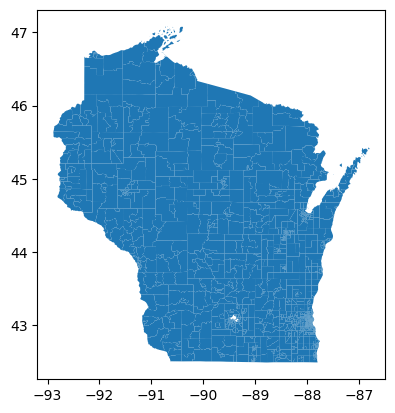

In [5]:
# Create a geographic plot
df.plot()

### Predicting "DTH_CUM_CP"

### How can we get a clean dataset of COVID deaths in WI?

In [6]:
# Replace -999 with 2; 2 is between 0-4; random choice instead of using 0
df = df.replace(-999, 2) 
# we must communicate in final results what percent of values were guessed (imputed)

How would we know if the data is now clean?

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

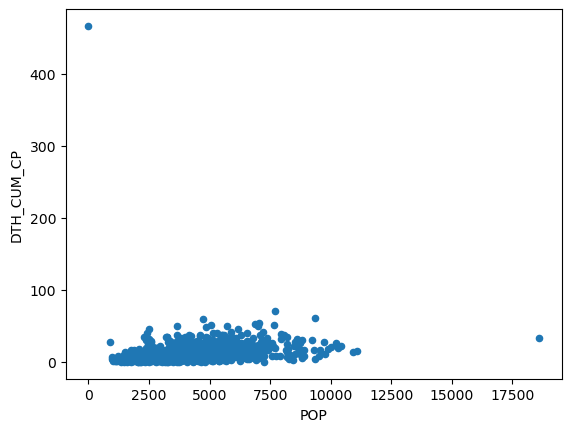

In [7]:
# Create a scatter plot to visualize relationship between "POP" and "DTH_CUM_CP"
df.plot.scatter(x="POP", y="DTH_CUM_CP")

Which points are concerning? Let's take a closer look.

#### Which rows have "DTH_CUM_CP" greater than 300?

In [8]:
df[df["DTH_CUM_CP"] > 300]

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
1392,1680894000000,TRACT N/A,NaN,51289,15,17.29,466,1,0.14,0,...,22536,26772,1680760800000,0,NaN,1014,Census tract,466.180086,80.071546,"POLYGON ((-87.04159 44.13490, -87.04161 44.134..."


#### Valid rows have "GEOID" that only contains digits

Using `str` methods to perform filtering: `str.fullmatch` does a full string match given a reg-ex. Because it does full string match anchor characters (`^`, `$`) won't be needed.

In [9]:
df["GEOID"]

0       55001950100
1       55001950201
2       55001950202
3       55001950400
4       55001950501
           ...     
1388    55141011400
1389    55141011500
1390    55141011600
1391    55141011700
1392      TRACT N/A
Name: GEOID, Length: 1393, dtype: object

In [10]:
df["GEOID"].str.fullmatch(r"\d+")

0        True
1        True
2        True
3        True
4        True
        ...  
1388     True
1389     True
1390     True
1391     True
1392    False
Name: GEOID, Length: 1393, dtype: bool

<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

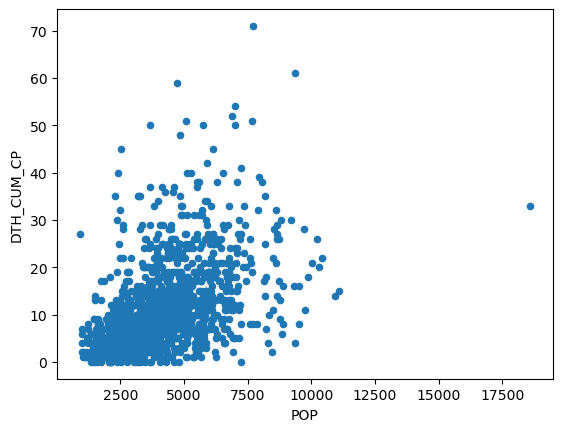

In [11]:
df = df[df["GEOID"].str.fullmatch(r"\d+")]
df.plot.scatter(x="POP", y="DTH_CUM_CP")

### How can we train/fit models to known data to predict unknowns?
- Feature(s) => Predictions
    - Population => Deaths
    - Cases => Deaths
    - Cases by Age => Deaths
    
- General structure for fitting models:
    ```python
    model = <some model>
    model.fit(X, y)
    y = model.predict(X)
    ```
    - where `X` needs to be a matrix or a `DataFrame` and `y` needs to be an array (vector) or a `Series`
    - after fitting, `model` object instance stores the information about relationship between features (x values) and predictions (y values)
    - `predict` returns a `numpy` array, which can be treated like a list

### Predicting "DTH_CUM_CP" using "POP" as feature.

In [12]:
# We must specify a list of columns to make sure we extract a DataFrame and not a Series
# Feature DataFrame
df[["POP"]].head()

,POP
0,2870
1,1244
2,2599
3,4533
4,1603


In [13]:
# Label Series: "DTH_CUM_CP"
df["DTH_CUM_CP"].head()

0    13
1     5
2     8
3    26
4     0
Name: DTH_CUM_CP, dtype: int64

### Let's use `LinearRegression` model.

- `from sklearn.linear_model import LinearRegression`

In [14]:
xcols = ["POP"]
ycol = "DTH_CUM_CP"

model = LinearRegression()
model.fit(df[xcols], df[ycol])
# less interesting because we are predicting what we already know
y = model.predict(df[xcols])

Predicting for new values of x.

In [15]:
predict_df = pd.DataFrame({"POP": [1000, 2000, 3000]})
predict_df

,POP
0,1000
1,2000
2,3000


In [16]:
# Predict for the new data
model.predict(predict_df)

array([3.95036044, 6.35121596, 8.75207149])

In [17]:
# Insert a new column called "predicted deaths" with the predictions
predict_df["predicted deaths"] = model.predict(predict_df)
predict_df

,POP,predicted deaths
0,1000,3.950360
1,2000,6.351216
2,3000,8.752071


### How can we visualize model predictions?

- Let's predict deaths for "POP" ranges like 0, 1000, 2000, ..., 20000

In [18]:
predict_df = pd.DataFrame({"POP": range(0, 20000, 1000)})
predict_df

,POP
0,0
1,1000
2,2000
3,3000
4,4000
5,5000
6,6000
7,7000
8,8000
9,9000


In [19]:
# Insert a new column called "predicted deaths" with the predictions
predict_df["predicted deaths"] = model.predict(predict_df)
predict_df

,POP,predicted deaths
0,0,1.549505
1,1000,3.950360
2,2000,6.351216
3,3000,8.752071
4,4000,11.152927
5,5000,13.553783
6,6000,15.954638
7,7000,18.355494
8,8000,20.756349
9,9000,23.157205


<AxesSubplot:xlabel='POP', ylabel='DTH_CUM_CP'>

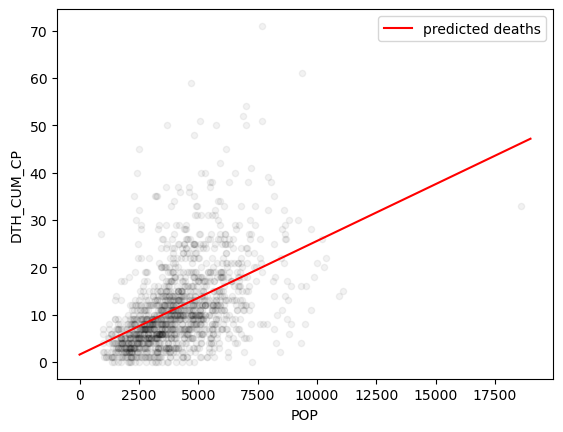

In [20]:
# Create a line plot to visualize relationship between "POP" and "predicted deaths"
ax = predict_df.plot.line(x="POP", y="predicted deaths", color="r")
# Create a scatter plot to visualize relationship between "POP" and "DTH_CUM_CP"
df.plot.scatter(x="POP", y="DTH_CUM_CP", ax=ax, color="k", alpha=0.05)

### How can we get a formula for the relationship?

- `y=mx+c`, where `y` is our predictions and `x` are the features used for the fit
    - Slope of the line (`m`) given by `model.coef_[0]`
    - Intercept of the line (`c`) given by `model.intercept_`

Model coefficients

In [21]:
model.coef_

array([0.00240086])

In [22]:
# Slope of the line
model.coef_[0]

0.0024008555243096655

In [23]:
# Intercept of the line
model.intercept_

1.5495049162803003

In [24]:
print(f"deaths ~= {round(model.coef_[0], 4)} * population + {round(model.intercept_, 4)}")

deaths ~= 0.0024 * population + 1.5495


### How well does our model fit the data?
- explained variance score
- R^2 ("r squared")

#### `sklearn.metrics.explained_variance_score(y_true, y_pred)`
- requires `import sklearn`
- calculates the explained variance score given:
    - y_true: actual death values in our example
    - y_pred: prediction of deaths in our example
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html

In [25]:
xcols, ycol

(['POP'], 'DTH_CUM_CP')

In [26]:
# Let's now make predictions for the known data
predictions = model.predict(df[xcols])
predictions

array([ 8.43996027,  4.53616919,  7.78932842, ..., 14.97748986,
       13.54177826, 12.17809232])

In [27]:
sklearn.metrics.explained_variance_score(df[ycol], predictions)

0.21575697888643763

#### Explained variance score

- `explained_variance = (known_var - explained_variance) / known_var`
    - where `known_var = y_true.var()` and `explained_variance = (y_true - y_pred).var()`

What is the variation in known deaths?

In [28]:
# Compute variance of "DTH_CUM_CP" column
known_var = df[ycol].var()
known_var

81.47782336365947

In [29]:
# explained_variance
explained_variance = (df[ycol] - predictions).var()   
explained_variance

63.89841434847359

In [30]:
# explained_variance score
explained_variance_score = (known_var - explained_variance) / known_var
explained_variance_score

0.21575697888643652

In [31]:
# For comparison here is the explained variance score from sklearn
sklearn.metrics.explained_variance_score(df[ycol], predictions)

0.21575697888643763

#### `sklearn.metrics.r2_score(y_true, y_pred)`

- requires `import sklearn`
- calculates the explained variance score given:
    - y_true: actual death values in our example
    - y_pred: prediction of deaths in our example
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html 

In [32]:
sklearn.metrics.r2_score(df[ycol], predictions)

0.21575697888643763

#### R^2 score (aka coefficient of determination) approximation

- `r2_score = (known_var - r2_val) / known_var`
    - where `known_var = y_true.var()` and `r2_val = ((y_true - y_pred) ** 2).mean()`

In [33]:
# r2_val
r2_val = ((df[ycol] - predictions) ** 2).mean()
r2_val

63.85251031517727

In [34]:
r2_score = (known_var - r2_val) / known_var
r2_score # there might be minor rounding off differences

0.21632037186137443

#### `model.score(X, y)`
- invokes `predict` method for calculating predictions (`y`) based on features (`X`) and compares the predictions with true values of y

In [35]:
model.score(df[xcols], df[ycol])  

0.21575697888643763

#### Did our model learn, or just memorize (that is, "overfit")?

- Split data into train and test

In [36]:
# Split the data into two equal parts
len(df) // 2

696

In [37]:
# Manual way of splitting train and test data
train, test = df.iloc[:len(df)//2], df.iloc[len(df)//2:]
len(train), len(test)

(696, 696)

Problem with manual splitting is, we need to make sure that the data is not sorted in some way.

#### `train_test_split(<dataframe>, test_size=<val>)`

- requires `from sklearn.model_selection import train_test_split`
- shuffles the data and then splits based on 75%-25% split between train and test
    - produces new train and test data every single time
- `test_size` parameter can take two kind of values:
    - actual number of rows that we want in test data
    - fractional number representing the ratio of train versus test data
    - default value is `0.25`
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [38]:
train, test = train_test_split(df)
len(train), len(test)

(1044, 348)

In [39]:
# Test size using row count
train, test = train_test_split(df, test_size=120)
len(train), len(test)

(1272, 120)

In [40]:
# Test size using fraction
train, test = train_test_split(df, test_size=0.5)
len(train), len(test)

(696, 696)

In [41]:
# Running this cell twice will give you two different train datasets
train, test = train_test_split(df)
train.head()

,RptDt,GEOID,GEOName,POS_CUM_CP,POS_NEW_CP,POS_7DAYAVG_CP,DTH_CUM_CP,DTH_NEW_CP,DTH_7DAYAVG_CP,DTH_OVER_30DAYS_CP,...,HOSP_NO_CP,HOSP_UNK_CP,Date,POP,POP_MOE,OBJECTID,GEO,Shape.STArea(),Shape.STLength(),geometry
1363,1680894000000,55139002700,NaN,831,0,0.14,3,0,0.0,0,...,648,148,1680760800000,2504,258.0,2280,Census tract,3.692688e+06,9961.540119,"POLYGON ((-88.43324 44.21539, -88.43702 44.215..."
198,1680894000000,55025003200,NaN,700,0,0.71,1,0,0.0,0,...,293,407,1680760800000,2926,261.0,3100,Census tract,4.547333e+06,13029.517186,"POLYGON ((-89.42098 43.07823, -89.42148 43.078..."
964,1680894000000,55095961000,NaN,1795,0,0.14,36,0,0.0,0,...,1193,533,1680760800000,4590,230.0,2223,Census tract,2.058972e+08,72465.341534,"POLYGON ((-92.31634 45.29585, -92.32564 45.295..."
693,1680894000000,55079015900,NaN,1435,0,0.86,11,0,0.0,0,...,747,602,1680760800000,3460,446.0,2786,Census tract,8.825646e+05,3817.445944,"POLYGON ((-87.94226 43.01910, -87.94225 43.019..."
350,1680894000000,55043960900,NaN,1667,0,0.29,7,0,0.0,0,...,829,794,1680760800000,5046,306.0,2812,Census tract,5.596763e+07,38511.778221,"POLYGON ((-90.42630 42.77660, -90.42679 42.776..."


In [42]:
train, test = train_test_split(df)

# Let's use the train and the test data
model = LinearRegression()
# Fit using training data
model.fit(train[xcols], train[ycol])
# Predict using test data
y = model.predict(test[xcols])
# We can use score directly as it automatically invokes predict
model.score(test[xcols], test[ycol])

0.2238498167305384

Running the above cell again will give you entirely different model and score.

#### How can we minimize noise due to random train/test splits?

### Cross validation: `cross_val_score(estimator, X, y)`

- requires `from sklearn.model_selection import cross_val_score`
-  do many different train/test splits of the values, fitting and scoring the model across each combination
- documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [43]:
train, test = train_test_split(df)

model = LinearRegression()
scores = cross_val_score(model, train[xcols], train[ycol])
scores

array([0.10596008, 0.24991963, 0.08773383, 0.19833743, 0.25939468])

In [44]:
# Compute mean of the scores
scores.mean()

0.1802691310372521

#### How can we compare models?
- model 1: POP => DEATHS
- model 2: CASES (POS_CUM_CP) => DEATHS

In [45]:
model1 = LinearRegression()
model2 = LinearRegression()
model1_scores = cross_val_score(model1, train[["POP"]], train[ycol])
model2_scores = cross_val_score(model2, train[["POS_CUM_CP"]], train[ycol])

In [46]:
model1_scores.mean()

0.1802691310372521

In [47]:
model2_scores.mean()

0.22915307983338623

Which of these two models do you think will perform better? Probably model2.

<AxesSubplot:>

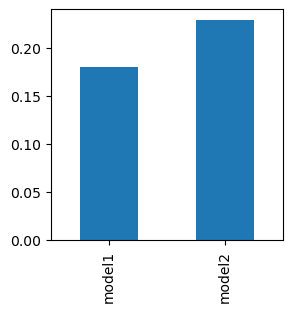

In [48]:
means = pd.Series({"model1": model1_scores.mean(),
                   "model2": model2_scores.mean()})
means.plot.bar(figsize=(3, 3))

How do we know the above difference is not noise? Let's calculate standard deviation and display error bars on the bar plot.

In [49]:
model1_scores.std()

0.07144665878218347

In [50]:
model2_scores.std()

0.08321894252440726

In [51]:
err = pd.Series({"model1": model1_scores.std(),
                 "model2": model2_scores.std()})
err

model1    0.071447
model2    0.083219
dtype: float64

<AxesSubplot:>

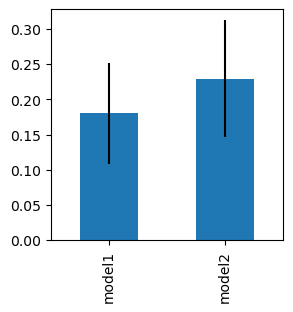

In [52]:
# Plot error bar by passing argument to paramenter yerr
means.plot.bar(figsize=(3, 3), yerr=err)

Pick a winner and run it one more time against test data.

#### How can we use multiple x variables (multiple regression)?

In [53]:
model = LinearRegression()
xcols = ['POS_0_9_CP', 'POS_10_19_CP', 'POS_20_29_CP', 'POS_30_39_CP',
       'POS_40_49_CP', 'POS_50_59_CP', 'POS_60_69_CP', 'POS_70_79_CP',
       'POS_80_89_CP', 'POS_90_CP']
ycol = "DTH_CUM_CP"

model.fit(train[xcols], train[ycol])
model.score(test[xcols], test[ycol]) 

0.6650938757320155

#### How can we interpret what features the model is relying on?

In [54]:
model.coef_

array([-0.02831411,  0.00185036, -0.00180267,  0.01456699,  0.01235213,
       -0.01054311,  0.02334617, -0.01161435,  0.13046548,  0.15250337])

<AxesSubplot:>

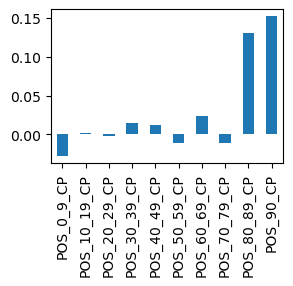

In [55]:
pd.Series(model.coef_, index=xcols).plot.bar(figsize=(3, 2))